# Audio Analysis

In this module, we'll look at audio signal representations of music from which we can obtain musical information (aka, music information retrieval). In order to do achieve this, we need to analyze audio signals, and some knowledge of how DSP, DFT, and other common techniques might be useful, but we wont go into here.

Our sections will be divided in four categories: 
- rhythm
- melody
- harmony
- synchronization

After this module, we would be ready to get the necessary data to work with some machine learning techniques.

---
## A bit of history

This type of music analysis has been around 20 or more years, ever since computers and computer music software became cheaper and more powerful. Luckily, we can have a list of software to choose from to begin working: http://ismir.net/resources/software-tools/

We'll use mostly `librosa`, which is a well documented, strong python module. Its origins come from Columbia university's "labrosa" (https://labrosa.ee.columbia.edu/) and its main author is Brian McFee

You can read the docs, here: http://librosa.org/docs. Colab already has librosa, and you can obtain the latest librosa running `pip3 install librosa` on your machine.

Many of these examples have been adapted from https://musicinformationretrieval.com/ and the FMP notebooks: https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html





# Beat Tracking

Automatic extraction of rhythmic pulse from musical excerpts. Also called beat-tracking and foot-tapping (SCHEIRER 1996). Automatic beat detection / beat tracking (ALONSO 2004)

## Beat

The sequence of equally spaced phenomenal impulses which define a tempo for the music.

## Pulse

A rhythmic pulse is described in terms of a frequency and phase component, just as for a periodic sound waveform (i.e., pitcH, or a note). **The frequency of the pulse in a rhythmic musical signal is the tempo or rate of the rhythm, and the phase of the pulse indicates where the _downbeat_ of the rhythm occurs**

## Usage 

- musical analysis,
- automatic rhythm alignment of multiple musical instruments, 
- cut and paste operations in audio editing,
- beat driven special effects


## Algorithm structure

1. a frontend analysis that efficiently extracts onsets
2. a periodicity detection block
3. the temporal estimation of beat locations

![beat-tracking](https://drive.google.com/uc?id=1fiOMa3BcwqcWCtLTNM2j3zOk-DkGKc7C)


The image above comes from Frieler 2004.


# Imports

librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems. https://librosa.org/doc/latest/index.html

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (12, 5)
from google.colab import drive
import glob
drive.mount('/content/drive')
from ipywidgets import interact

Mounted at /content/drive


# Audio Signal

In [2]:
filename = "/content/drive/MyDrive/python_scratch/audio/admiralbob77_-_Choice_-_Drum-bass.ogg"
y, sr = librosa.load(filename, duration=10) # default sr = 22050
ipd.Audio(y, rate=sr)

# Librosa's Beat Tracking

In [3]:
hop_length = 512
start_bpm = 120.
tightness_exp = 2.0
tempo = librosa.beat.tempo(y=y, 
                           hop_length=hop_length,
                           start_bpm=start_bpm, 
                           max_tempo=240.0,
                           aggregate=np.mean)
print(tempo[0])
bpm, beats = librosa.beat.beat_track(y=y, 
                                   sr=sr, 
                                   hop_length=hop_length,
                                   bpm=tempo[0],
                                   tightness=10**tightness_exp,)
print(beats)

135.99917763157896
[  3  21  40  59  78  96 116 135 154 173 192 211 230 249 268 287 306 325
 344 363]


Use the IPython interactive widgets to observe how the output changes as we vary the parameters of the beat tracker.

In [4]:
def f(hop_length, start_bpm, tightness_exp):

    tempo = librosa.beat.tempo(y=y, 
                                hop_length=hop_length,
                                start_bpm=start_bpm, 
                                max_tempo=240.0,
                                aggregate=np.mean)
    _, beats = librosa.beat.beat_track(y=y, 
                                sr=sr, 
                                hop_length=hop_length,
                                bpm=tempo[0],
                                tightness=10**tightness_exp,)
    return tempo, beats

interact(f,hop_length = 512, start_bpm = 120., tightness_exp = 2.0)

interactive(children=(IntSlider(value=512, description='hop_length', max=1536, min=-512), FloatSlider(value=12…

<function __main__.f>

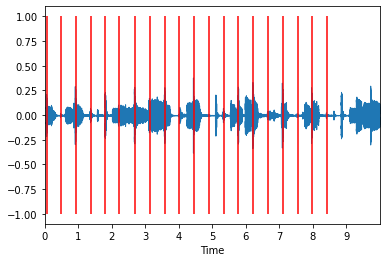

In [5]:
# optionally adjust edges
# beats_centered = np.concatenate([ [0], beats, [len(y)/hop_length] ]).astype(np.int32)
# print(beats_centered)

# convert to time units
beats_times = librosa.frames_to_time(beats,
                                     sr=sr,
                                     hop_length=hop_length)
# plot waveform
librosa.display.waveplot(y, sr=sr, x_axis='time')
# plot red vertical lines
plt.vlines(beats_times, -1, 1, colors='r')

## Listen

In [6]:
def audio_add(x,y):
    if x.shape[0] < y.shape[0] : y = y[:x.shape[0]]
    if y.shape[0] < x.shape[0] : x = x[:y.shape[0]]
    return np.array( x + y ) * 0.5

In [7]:
clicks = librosa.clicks(beats_times,sr=sr,length=len(y))
ipd.Audio( y + clicks, rate=sr)

# Spectral Analysis

In [8]:
n_fft = 4096
hop_length = 128
# short time fourier transform
D = librosa.stft(y, 
                 n_fft=n_fft, 
                 win_length=n_fft//2, 
                 hop_length=hop_length, 
                 window="hann",
                 center=True)

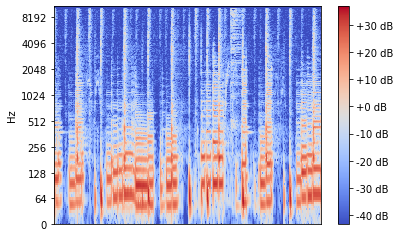

In [9]:
# take power spectrum
PS = np.abs(D)**2
# plot it
librosa.display.specshow(librosa.power_to_db(PS), y_axis='log')
plt.colorbar(format="%+2.0f dB")

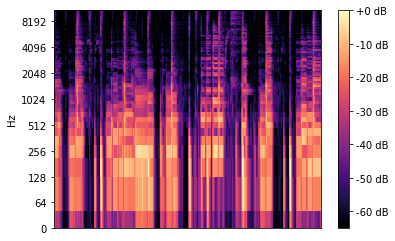

In [10]:
# Generate a mel-spectrogram
n_mels = 128
fmax = 9000
S = librosa.feature.melspectrogram(S=PS+0.001,
                                   n_mels=n_mels,
                                   fmax=fmax)
# Normalize by peak energy
S = S / S.max()

# Put on a log scale
S = librosa.power_to_db(S)
# plot
librosa.display.specshow(S, y_axis='log')
plt.colorbar(format="%+2.0f dB")

# Spectral Energy Flux
(aka. Onset Strength Envelope)

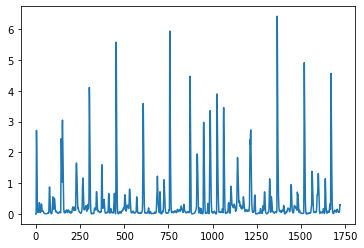

In [11]:
onset_strength = librosa.onset.onset_strength(S=S,
                                              detrend=False, 
                                              max_size=1, 
                                              lag=1)
# onset_strength = librosa.onset.onset_strength(y=y,sr=sr)
plt.plot(onset_strength)
# plt.vlines(beats, 0, onset_strength.max(), colors='r', linestyle='--')

## Custom onset strength function

In [12]:
# Onset strength function for beat tracking

# normalization helper function
def normalize(x):
    x -= x.min()
    x /= x.max()
    return x

def custom_onset(S, n=1):
    # S -= np.mean(S)
    n_order_diff =  np.diff(S, n=n, axis=1)
    half_wave_rect = np.maximum(0.0, n_order_diff)
    mean = np.mean(half_wave_rect, axis=0)
    onset_env = normalize(mean)
    return onset_env

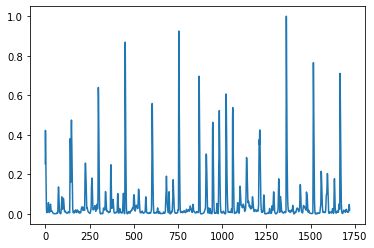

In [13]:
custom_onset_strength = custom_onset(S, n=1)
plt.plot(custom_onset_strength)

# Detection Function

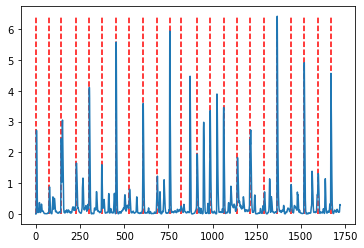

In [14]:
pre_max  = 0.05  # number of samples before n over which max is computed
post_max = 0.00  # number of samples after n over which max is computed
pre_avg  = 0.01   # number of samples before n over which mean is computed
post_avg = 0.10   # number of samples after n over which mean is computed
delta    = 0.07  # threshold offset for mean
wait     = 0.3   # number of samples to wait after picking a peak

peaks = librosa.util.peak_pick(onset_strength,
                                          pre_max*sr//hop_length,
                                          post_max*sr//hop_length+1,
                                          pre_avg*sr//hop_length,
                                          post_avg*sr//hop_length+1,
                                          delta,
                                          wait*sr//hop_length)
plt.plot(onset_strength)
plt.vlines(peaks, 0, onset_strength.max(), colors='r', linestyle='--')

## Listen

In [15]:
peak_times = librosa.frames_to_time(peaks, 
                                       sr=sr, 
                                       hop_length=hop_length)
peak_clicks = librosa.clicks(peak_times,sr=sr,hop_length=hop_length)
ipd.Audio(audio_add(peak_clicks, y), rate=sr)

In [16]:
print(peaks)

[   3   75  143  227  302  372  454  529  606  685  757  822  911  984
 1062 1139 1211 1292 1365 1443 1518 1594 1669]


# Periodicity Estimation

##  Autocorrelation

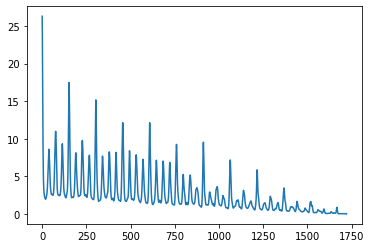

In [17]:
# r = librosa.autocorrelate(onset_strength, max_size=5000)
r = librosa.autocorrelate(custom_onset_strength, max_size=5000)
plt.plot(r)

In [20]:
def compute_autocor(onset_strength, i_min=240, i_max=40):
    r = librosa.autocorrelate(onset_strength, max_size=5000)
    # Define lower and upper limits for the autocorrelation argmax.
    # i_min = 240
    # i_max = 40

    r[:i_max] = 0
    r[i_min:] = 0

    # Find the location of the maximum autocorrelation.
    return r.argmax()
# plt.vlines(tempo_estimate,r.min(),r.max(),color='r')
# print(f'Tempo estimate: is {tempo_estimate} bpm')
# plt.plot(r)

## DFT

Tempo estimate with DFT is 135 bpm
[10, 22, 23, 33, 44, 45, 56, 67, 78, 89, 90, 101, 135]


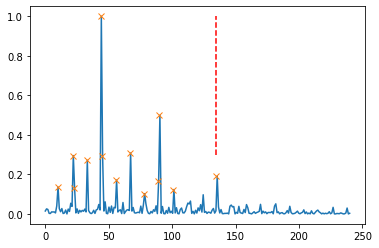

In [21]:
# compute the DFT of the onset strength envelope
p = np.fft.fft(onset_strength)
# p = np.fft.fft(custom_onset_strength)
# get rid of second half (symmetrical), and the first element
half_length = p.shape[0]//2
pabs_half = p[1:half_length-1]
# compute the power spectrum
pabs = np.abs(pabs_half)**2

# pabs = normalize(pabs)

# normalize
pabs -= pabs.min()
# pabs /= np.linalg.norm(pabs)
pabs /= pabs.max()

# plot the normalized power spectrum
max_x = 240
plot_x = np.linspace(0, max_x, max_x)
plot_y = pabs[:max_x]
plt.plot(plot_x,plot_y)

# filter points with a threshold
thresh = 0.1

points = [ i for i, x in enumerate(pabs[:max_x]) if x > thresh]

p_estimate = max(points)
# plot points and printout tempo estimate
plt.plot(points, pabs[points], 'x')
plt.vlines(p_estimate,0.3,1,colors='r',linestyles='--')
print(f'Tempo estimate with DFT is {p_estimate} bpm')
print(points)

# Essentia

In [22]:
!pip install essentia
from essentia.standard import *

     |████████████████████████████████| 12.0MB 6.1MB/s 


In [ ]:
# Loading audio file
audio = MonoLoader(filename=filename, sampleRate=sr)()

# Compute beat positions and BPM
rhythm_extractor = RhythmExtractor2013(method="multifeature")
e_bpm, e_beats, confidence, _, intervals = rhythm_extractor(audio)

print("BPM:", e_bpm)
print("Beats", e_beats)
print("Beat estimation confidence:", confidence)

# Mark beat positions on the audio and write it to a file
# Let's use beeps instead of white noise to mark them, 
# as it's more distinctive
marker = AudioOnsetsMarker(onsets=e_beats, type='beep')
marked_audio = marker(audio)
ipd.Audio(marked_audio, rate=sr)

## Compare Tempo Estimations

In [ ]:
print(int(bpm), "Librosa beats.beat_track")
print(int(tempo),"Librosa beats.tempo")
print(int(tempo_estimate),"Custom librosa with autocorrelation")
print(int(p_estimate),"Custom librosa with DFT")
print(int(e_bpm), "Essentia")

# References
These are some useful papers dealing with beat tracking and related tasks:

# References

The following list includes many articles that comment on beat tracking research. Some of it is quoted and used on this text, but others are just for the curious mind.

- Thanos Fouloulis, Aggelos Pikrakis, and Emilios Cambouropoulos. Traditional asymmetric rhythms: A refined model of meter induction based on asymmetric meter templates.
- Eric D. Scheirer. Tempo and beat analysis of acoustic musical signals. The Journal of the Acoustical Society of America, 103(1):588–601, 1998.
- Jean Laroche. Efficient tempo and beat tracking in audio recordings. Journal of the Audio Engineering Society (JAES), 51:226–, 04 2003.
- Miguel Alonso, Bertrand David, and GaA ̃l Richard. Tempo and beat estimation of musical signals. 10 2004.
- Klaus Frieler. Beat and meter extraction using gaussified onsets. 01 2004.
- S. Dixon. Onset detection revisited. In Proc. of the 9th Int. Conference on Digital Audio Effects (DAFx-06), Montreal, Canada, September 18-20, 2006, 2006.
- Daniel Ellis. Beat tracking by dynamic programming. Journal of New Music Research, 36:51–60, 03 2007.
- Andre Holzapfel and Yannis Stylianou. Beat tracking using group delay based onset detection. In Juan Pablo Bello, Elaine Chew, and Douglas Turnbull, editors, ISMIR 2008, 9th International Conference on Music Information Retrieval, Drexel University, Philadelphia, PA, USA, September 14-18, 2008, pages 653–658, 2008.
- Peter Grosche, Meinard Mu ̈ller, and Craig Stuart Sapp. What makes beat tracking difficult? A case study on chopin mazurkas. In J. Stephen Downie and Remco C. Veltkamp, editors, Proceedings of the 11th International Society for Music Information Retrieval Conference, ISMIR 2010, Utrecht, Netherlands, August 9-13, 2010, pages 649–654. International Society for Music Information Retrieval, 2010.
- Joao Lobato Oliveira, Fabien Gouyon, Luis Gustavo Martins, and Lu ́ıs Paulo Reis. IBT: A real-time tempo and beat tracking system. In J. Stephen Downie and Remco C. Veltkamp, editors, Proceedings of the 11th International Society for Music Information Retrieval Conference, ISMIR 2010, Utrecht, Netherlands, August 9-13, 2010, pages 291–296. International Society for Music Information Retrieval, 2010.
- Fu-Hai Frank Wu, Tsung-Chi Lee, Jyh-Shing Roger Jang, Kaichun K. Chang, Chun-Hung Lu, and Wen-Nan Wang. A two-fold dynamic programming approach to beat tracking for audio music with time-varying tempo. In Anssi Klapuri and Colby Leider, editors, Proceedings of the 12th International Society for Music Information Retrieval Conference, ISMIR 2011, Miami, Florida, USA, October 24-28, 2011, pages 191–196. University of Miami, 2011.
- S. Bock and G. Widmer. Maximum filter vibrato suppression for onset detection sebastian bock and gerhard widmer department of computational perception. 2013.
- S. Bock, F. Krebs, and G. Widmer. A multi-model approach to beat tracking considering heterogeneous music styles. In ISMIR, 2014.
- Filip Korzeniowski, Sebastian B ̈ock, and Gerhard Widmer. Probabilistic extraction of beat positions from a beat activation function. In Hsin-Min Wang, Yi-Hsuan Yang, and Jin Ha Lee, editors, Proceedings of the 15th International Society for Music Information Retrieval Conference, ISMIR 2014, Taipei, Taiwan, October 27-31, 2014, pages 513–518, 2014.
- Aggelos Gkiokas and Vassilis Katsouros. Convolutional neural networks for real-time beat tracking: A dancing robot application. In Sally Jo Cunningham, Zhiyao Duan, Xiao Hu, and Douglas Turnbull, editors, Proceedings of the 18th International Society for Music Information Retrieval Conference, ISMIR 2017, Suzhou, China, October 23-27, 2017, pages 286–293, 2017.
- Magdalena Fuentes, Brian McFee, Helene C. Crayencour, Slim Essid, and Juan Pablo Bello. Analysis of common design choices in deep learning systems for downbeat tracking. In Emilia G ́omez, Xiao Hu, Eric Humphrey, and Emmanouil Benetos, editors, Proceedings of the 19th International Society for Music Information Retrieval Conference, ISMIR 2018, Paris, France, September 23-27, 2018, pages 106–112, 2018.
- Andrew McLeod and Mark Steedman. Meter detection and alignment of MIDI performance. In Emilia G ́omez, Xiao Hu, Eric Humphrey, and Emmanouil Benetos, editors, Proceedings of the 19th International Society for Music Information Retrieval Conference, ISMIR 2018, Paris, France, September 23-27, 2018, pages 113–119, 2018.
- Bijue Jia, Jiancheng Lv, and Dayiheng Liu. Deep learning-based automatic downbeat tracking: a brief review. Multimedia Systems, 25(6):617–638, Mar 2019.
- E. P. MatthewDavies and S. Bock. Temporal convolutional networks for musical audio beat tracking. In 2019 27th European Signal Processing Conference (EUSIPCO), pages 1–5, 2019.
- Sebastian Block and Matthew E. P. Davies. Deconstruct, analyse, reconstruct: How to improve tempo, beat, and downbeat estimation. In Anssi Klapuri and Colby Leider, editors, Proceedings of the 21st International Society for Music Information Retrieval Conference, ISMIR 2020. Montreal, Canada, 2020.

# Exercise

Create a dataframe in Pandas that provides the tempo estimates of ten recordings on your computer, using the five methods discussed this week (Librosa beat_track, tempo, autocorrelation, DFT, and Essentia.

In [23]:
import pandas as pd

In [24]:
def dft_estimate(x, max_x=240, thresh=0.1):
    # compute the DFT of the onset strength envelope
    p = np.fft.fft(x)
    # p = np.fft.fft(custom_onset_strength)
    # get rid of second half (symmetrical), and the first element
    half_length = p.shape[0]//2
    pabs_half = p[1:half_length-1]
    # compute the power spectrum
    pabs = np.abs(pabs_half)**2

    # pabs = normalize(pabs)

    # normalize
    pabs -= pabs.min()
    # pabs /= np.linalg.norm(pabs)
    pabs /= pabs.max()

    # filter points with a threshold

    points = [ i for i, x in enumerate(pabs[:max_x]) if x > thresh]

    return max(points)


In [25]:
def autocor_estimate(x, max_size=5000, i_min=240, i_max=40):
    r = librosa.autocorrelate(x, max_size=max_size)


    r[:i_max] = 0
    r[i_min:] = 0

    # Find the location of the maximum autocorrelation.
    return r.argmax()

In [26]:
hop_length = 512
start_bpm = 120.
tightness_exp = 2.0
n_mels = 128
fmax = 9000
pre_max  = 0.05  # number of samples before n over which max is computed
post_max = 0.00  # number of samples after n over which max is computed
pre_avg  = 0.01   # number of samples before n over which mean is computed
post_avg = 0.10   # number of samples after n over which mean is computed
delta    = 0.07  # threshold offset for mean
wait     = 0.3   # number of samples to wait after picking a peak

# Define lower and upper limits for the autocorrelation argmax.
i_min = 240
i_max = 40
thresh = 0.1

duration = 30

dataArray = []

def cooked_bpm(f):
    if "1030011" in f:
        return 126
    elif "1068430" in f:
        return 170
    elif "1084996" in f:
        return  140
    elif "1092771" in f:
        return  136
    elif "1114156" in f:
        return  86
    elif "1118326" in f:
        return  171.419
    elif "1120171" in f:
        return  174
    elif "1171800" in f:
        return  140


where = "/content/drive/MyDrive/python_scratch/audio/giant_steps_small/*.mp3"

file_list = [f for f in glob.glob(where)]



for filename in file_list:

    y, sr = librosa.load(filename, duration=duration) # default sr = 22050

    librosa_tempo = librosa.beat.tempo(y=y, 
                            hop_length=hop_length,
                            start_bpm=start_bpm, 
                            max_tempo=240.0,
                            aggregate=np.mean)[0]

    _, librosa_beats = librosa.beat.beat_track(y=y, 
                                    sr=sr, 
                                    hop_length=hop_length,
                                    bpm=librosa_tempo,
                                    tightness=10**tightness_exp,)

    # short time fourier transform
    D = librosa.stft(y, 
                    n_fft=n_fft, 
                    win_length=n_fft//2, 
                    hop_length=hop_length, 
                    window="hann",
                    center=True)

    # take power spectrum
    PS = np.abs(D)**2

    S = librosa.feature.melspectrogram(S=PS+0.001,
                                    n_mels=n_mels,
                                    fmax=fmax)

    # Normalize by peak energy
    S = S / S.max()

    librosa_os = librosa.onset.onset_strength(S=S,
                                                detrend=False, 
                                                max_size=1, 
                                                lag=1)
    custom_os = custom_onset(S, n=1)

    librosa_beats_librosa_os = librosa.util.peak_pick(librosa_os,
                                            pre_max*sr//hop_length,
                                            post_max*sr//hop_length+1,
                                            pre_avg*sr//hop_length,
                                            post_avg*sr//hop_length+1,
                                            delta,
                                            wait*sr//hop_length)

    librosa_beats_custom_os = librosa.util.peak_pick(custom_os,
                                            pre_max*sr//hop_length,
                                            post_max*sr//hop_length+1,
                                            pre_avg*sr//hop_length,
                                            post_avg*sr//hop_length+1,
                                            delta,
                                            wait*sr//hop_length)

    tempo_aut_est_librosa_os = autocor_estimate(librosa_os, i_min=i_min, i_max=i_max)
    tempo_dft_est_librosa_os = dft_estimate(librosa_os, max_x=i_min, thresh=thresh)

    tempo_aut_est_custom_os = autocor_estimate(custom_os, i_min=i_min, i_max=i_max)
    tempo_dft_est_custom_os = dft_estimate(custom_os, max_x=i_min, thresh=thresh)

    rhythm_extractor = RhythmExtractor2013()

    # Compute beat positions and BPM
    e_bpm, e_beats, _, _, _ = rhythm_extractor(y)



    fname = filename.split('/')[-1]
    dataArray.append(list([
            fname,
            len(librosa_beats), 
            len(librosa_beats_librosa_os), 
            len(librosa_beats_custom_os), 
            len(e_beats),
            librosa_tempo, 
            tempo_aut_est_librosa_os, 
            tempo_dft_est_librosa_os, 
            tempo_aut_est_custom_os, 
            tempo_dft_est_custom_os, 
            e_bpm,
            cooked_bpm(fname),
        ]))
###### loop ends here ---------------------------------------------------

columns=list([
              "File Name",
              "Librosa Beat Tracking",
              "Librosa Peaks w/ Librosa OS",
              "Librosa Peaks w/ Custom OS",
              "Essentia Beat Tracking",
              "Librosa Tempo",
              "Autocorr w/ Librosa OS",
              "Autocorr w/ Custom OS",
              "DFT estimate w/ Librosa OS",
              "DFT estimate w/ Custom OS",
              "Essentia Tempo",
              "Cooked BPM",
              ])

pd.DataFrame(data=dataArray, columns=columns)


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

File Name  Librosa Beat Tracking  ...  Essentia Tempo  Cooked BPM
0  1030011.LOFI.mp3                     82  ...       83.303864     126.000
1  1068430.LOFI.mp3                     57  ...       86.684395     170.000
2  1084996.LOFI.mp3                     60  ...       68.772003     140.000
3  1092771.LOFI.mp3                     52  ...       67.999596     136.000
4  1114156.LOFI.mp3                     42  ...       85.984192      86.000
5  1118326.LOFI.mp3                     85  ...      114.075554     171.419
6  1120171.LOFI.mp3                     42  ...       86.606300     174.000
7  1171800.LOFI.mp3                     68  ...       70.016792     140.000

[8 rows x 12 columns]

In [ ]:
where = "/content/drive/MyDrive/python_scratch/audio/giant_steps_small/*.mp3"

file_list = [f for f in glob.glob(where)]


array_of_sound, samplerate_integer = librosa.load(file_list[0], duration=30)
# print(y.shape[0]/sr)

# Librosa beat_track
tempo, beats = librosa.beat.beat_track(array_of_sound, samplerate_integer)

# Librosa's tempo
tempo

# Librosa's onset strength autocorrelation

# Custom onset strength autocorrelation
# Librosa's onset strength DFT method

# Custom  onset strength DFT method

# Essentia's beat tracking algorithm



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


30.0


In [ ]:
import librosa as librosa

In [ ]:
seconds_of_file = 10
hop_length = 512
start_bpm = 120.
n_fft = 4096
hop_length = 128
fmax = 9000
n_mels = 128

y, sr = librosa.load(file_list[0], duration=seconds_of_file)

tempo = librosa.beat.tempo(y=y, 
                           hop_length=hop_length,
                           start_bpm=start_bpm, 
                           max_tempo=240.0,
                           aggregate=np.mean)

## compute onset strength envelope
def compute_onset_strength(audio):
    # short time fourier transform
    D = librosa.stft(y=audio, 
                    n_fft=n_fft, 
                    win_length=n_fft//2, 
                    hop_length=hop_length, 
                    window="hann",
                    center=True)

    # Generate a mel-spectrogram

    # take power spectrum
    PS = np.abs(D)**2

    S = librosa.feature.melspectrogram(S=PS+0.001,
                                    n_mels=n_mels,
                                    fmax=fmax)
    # Normalize by peak energy
    S = S / S.max()


    return custom_onset(S)

custom_onset_envelope = compute_onset_strength(y)

print(tempo)


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[172.265625]


In [ ]:
print(librosa.note_to_hz("C1"))

32.70319566257483
